In [1]:
import json
import copy
import re
import numpy as np
import pandas as pd
import torch
import random
import sklearn
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import copy
from scipy.stats.stats import pearsonr   
plt.rc('font', family='Malgun Gothic')
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [17]:
print('numpy version : {}, pandas version : {}, pytorch version : {}'.format(np.__version__, pd.__version__, torch.__version__))

numpy version : 1.17.0, pandas version : 1.0.5, pytorch version : 1.6.0


## 1/26 ~ 9/23 데이터셋 List

* 확진자 Y

* 13개 Input X

* 뉴스 크롤링 : 코로나_단계, 마스크_의무화, 코로나_고위험_시설
* 검색어 트렌드 : 사회적거리두기, 집단감염+집단발병
* 불쾌지수
* clustered 감염자 : age(3개) area(4개)

## 1. 감염자 시계열 데이터 준비(y) : 1/26 ~ 9/23

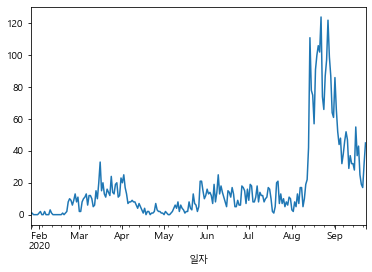

In [11]:
#change datatype to datetime
def dtchange(date):
    year, month, day = [x.strip() for x in date.split('.')[:-1]]
    if int(month) < 10:
        dtime = datetime.strptime(year+'0'+month+day, '%Y%m%d').date()
    else:
        dtime = datetime.strptime(year+month+day, '%Y%m%d').date()
    return dtime

#entiredata.csv = 감염병관리지원단에서 다운받은 rawdata, 1/26~현재날짜까지
data = pd.read_csv('entiredata.csv')

series = pd.DataFrame(data = {'확진일자':data['확진일자'], '레코드 수':data['레코드 수']})
series['확진일자'] = list(map(dtchange, series['확진일자']))
series = series.groupby('확진일자').sum().sort_values(by=['확진일자'], axis=0)

drange = pd.date_range(start = series.index[0], end = series.index[-2])
drange = [x.date() for x in drange]
infected = []
for date in drange:
    if date in series.index:
        infected.append(int(series[series.index == date].values))
    else:
        infected.append(0)
        
infected_series = pd.Series(infected, index = pd.to_datetime(drange), name='감염자')
infected_series.index.name = '일자'

infected_series.to_csv('감염자시계열.csv', encoding = 'utf-8-sig')

infected_series.plot()

## 2. Input X 데이터 preprocessing (1/26 ~ 9/23)

In [13]:
# 뉴스기사 (변수 3개)
news = pd.read_csv('news_crawling_0923.csv', encoding = 'cp949')
start = list(news['Date']).index('2020-01-26')
end = list(news['Date']).index('2020-09-23')
news = news.iloc[start:end+1, :].reset_index(drop=True)
news.index = pd.to_datetime(news['Date'])
news = news.drop(['Date'], axis = 1)

# 검색어 트렌드 (변수 2개)
trend_distance = pd.read_excel('사회적거리두기+거리두기+사회적거리.xlsx', header = None)
trend_group = pd.read_excel('집단감염+집단발병.xlsx', header = None)

# 기상청 데이터로부터 불쾌지수 데이터 만들기
whether = pd.read_csv('경기도기상청0923까지_지역합침.csv', encoding='cp949')[['일시', '평균기온(°C)', '평균 상대습도(%)']]
whether.columns = ['Date', '기온', '습도']
start = list(whether['Date']).index('2020-01-26')
end = list(whether['Date']).index('2020-09-23')
whether = whether.iloc[start:end+1, :].reset_index(drop=True)
temperature, humidity = whether['기온'], whether['습도']/100

discomfort = (9/5*temperature) - (0.55*(1-humidity)*(((9/5*temperature) - 26))) + 32
whether['불쾌지수'] = discomfort
whether = whether.drop(['기온', '습도'], axis =1)

#clusered 감염자 + 비어있는 날짜 0처리
defaultdata = pd.read_csv('기본데이터기반_변수0923.csv', encoding = 'cp949').drop(['무증상비율', 'Primary비율'], axis=1)
date = pd.to_datetime(defaultdata['확진일자'])
defaultdata.index = date
defaultdata = defaultdata.drop(['확진일자'], axis = 1)

defaultdata = dict(defaultdata)
for key, series in defaultdata.items():
    drange = pd.date_range(start = date[0], end = date[len(date)-1])
    #drange = [x.date() for x in drange]
    series_filled = []
    for date_ in drange:
        if date_ in series.index:
            series_filled.append(float(series[series.index == date_].values))
        else:
            series_filled.append(0)
    defaultdata[key] = pd.Series(series_filled, index = drange)
    
# whether에 모든 데이터 이어붙여 total_variable 만들기
whether['검색어_거리두기'] = trend_distance[1]
whether['검색어_집단'] = trend_group[1]
whether['감염자'] = infected_series.values
for k, v in defaultdata.items():
    whether[k] = list(v)
    
total_variable = copy.deepcopy(whether)
total_variable.index = pd.to_datetime(total_variable['Date'])
total_variable = total_variable.drop(['Date'],axis=1)

total_variable = pd.concat([total_variable, news], axis=1)
print(total_variable.columns)
total_variable.head()


Index(['불쾌지수', '검색어_거리두기', '검색어_집단', '감염자', 'age_cluster_1', 'age_cluster_2',
       'age_cluster_0', 'area_cluster_1', 'area_cluster_3', 'area_cluster_2',
       'area_cluster_0', '코로나_단계', '마스크_의무화', '코로나_고위험_시설'],
      dtype='object')


,불쾌지수,검색어_거리두기,검색어_집단,감염자,age_cluster_1,age_cluster_2,age_cluster_0,area_cluster_1,area_cluster_3,area_cluster_2,area_cluster_0,코로나_단계,마스크_의무화,코로나_고위험_시설
Date,,,,,,,,,,,,,,
2020-01-26,42.953416,0.00045,0.00000,1,0.0,0.0,0.5,0.111111,0.0,0.0,0.0,1,3,0
2020-01-27,45.892428,0.00096,0.00000,1,0.0,0.0,0.5,0.111111,0.0,0.0,0.0,6,3,1
2020-01-28,47.307743,0.00096,0.78534,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,12,28,8
2020-01-29,43.756836,0.00086,0.35994,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,10,5,18
2020-01-30,42.877617,0.00050,0.00000,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,10,1,27


In [14]:
total_variable.shape

(242, 14)

## 3. Variables plot

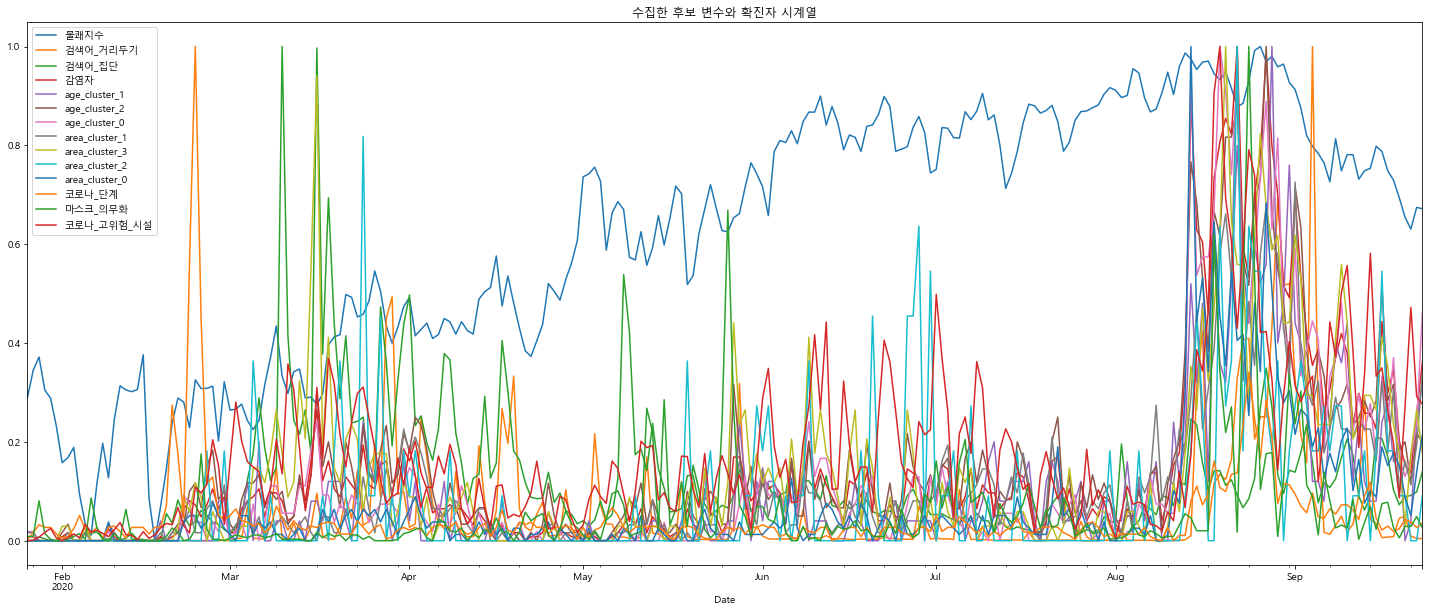

In [15]:

tmp = copy.deepcopy(total_variable)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(tmp)
scaled_df = pd.DataFrame(scaled, columns=total_variable.columns, index = total_variable.index)
scaled_df.plot(title= '수집한 후보 변수와 확진자 시계열', fontsize = 10, figsize = (25, 10))

## 4. 변수 선별을 위한 Correlation test, time-lag estimation

C:\Anaconda3\envs\simpletransformers\lib\site-packages\ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


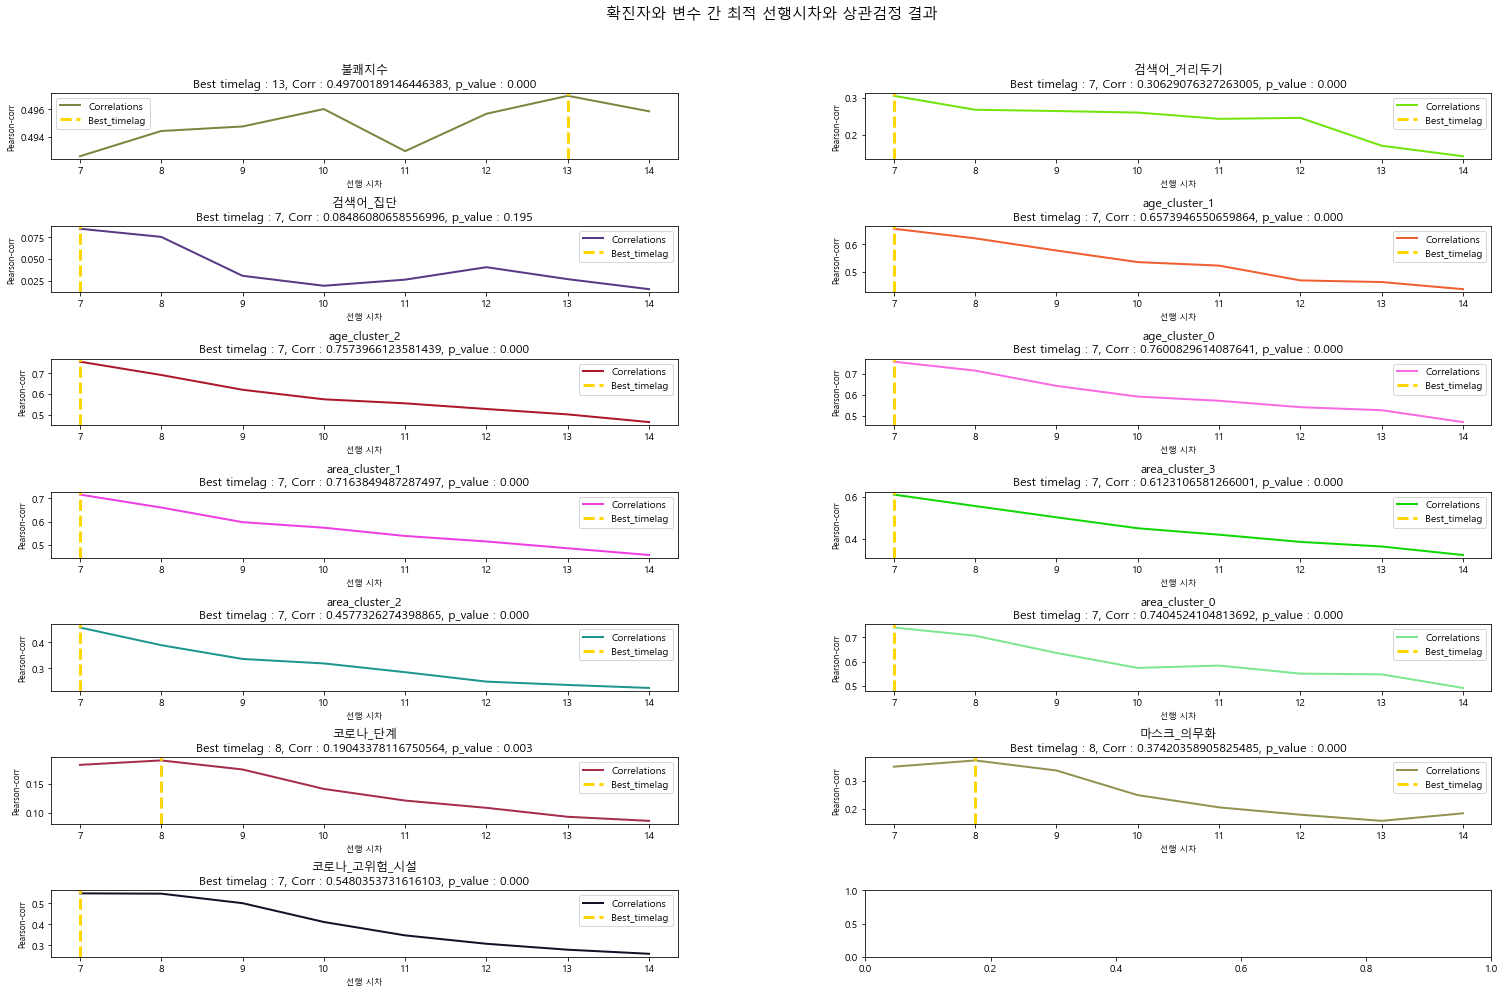

In [16]:
#shift값은 양수로 7부터 시작해야함

'''
results = {}
best_results = {}
1. 확진자, 검정대상 시계열 가져오기
2. 7부터 15까지 의 lag에 대해서 [correlation, p_value] 구해서
    corrs = [], p_values = []에 저장
    result = [corrs, p_values]
    
    best_corr = max(corrs) 가져오고, 
    best_p_value = p_values[argmax(corrs)]
    optimal_timelag = 7 + argmax(corrs)
    
    results = {'name' : result} 형태로 저장 
    best_results = {'name' : [best_corr, best_p_value, optimal_timelag]} 형태로
    
3. 변수 13개 7*2로 subplots활용
'''

#변수마다 7~15의 timelag에 대한 correlation test 후 best correlation/timelag 저장

results = {}
best_results = {}
df = copy.deepcopy(total_variable)
infected = df['감염자']
df = df.drop(['감염자'], axis = 1)

for colname in df.columns:
    target = df[colname]
    corrs, p_values = [], []
    for lag in range(7, 15):
        correlation, p_value = pearsonr(infected[lag:], target[:-lag])
        corrs.append(correlation), p_values.append(p_value)
    
    best_corr = max(corrs)
    best_p_value = p_values[np.argmax(corrs)]
    optimal_timelag = 7 + np.argmax(corrs)
    
    results[colname] = [corrs, p_values]
    best_results[colname] = [best_corr, best_p_value, optimal_timelag]
    

# show test result
fig, axes = plt.subplots(nrows = 7, ncols = 2, figsize = (25, 15))

plt.subplots_adjust(left = 0.1, right = 0.9, top= 0.9, bottom = 0.1,  wspace = 0.3, hspace= 1)
#p1,p2,p3s,p4,p5,p6,p7,p8,p9,p10 = ax

for name, ax in zip(results.keys(), axes.flatten()):
    correlations = results[name][0]
    best_corr, best_p_value, best_timelag = best_results[name]
    r, g, b = random.random(), random.random(), random.random()
    ax.plot(range(7, 15), correlations, color = (r, g, b), label='Correlations', linewidth = 2)
    
    #ax.axvline(np.ceil(len(rs)/2), color='k', linestyle='--', label = 'Center')
    ax.axvline(7+np.argmax(correlations), color = 'gold', linestyle = '--', label='Best_timelag', linewidth=3)
    
    ax.set_xlabel('선행 시차', size='small')
    ax.set_ylabel('Pearson-corr', size = 'small')
    ax.set_title(name+'\nBest timelag : {}, Corr : {}, p_value : {:.3f}'.format(best_timelag, best_corr, best_p_value), size='medium', fontsize=12)
    ax.legend()
fig.suptitle('확진자와 변수 간 최적 선행시차와 상관검정 결과', fontsize = 15)
fig.show()
    


### 4. 최종 선정 된 12개 시계열 변수 X, 확진자 시계열 Y 저장

In [23]:
var_to_use = total_variable.drop(['검색어_집단'], axis = 1)
var_to_use.to_csv('var_to_use.csv', encoding = 'utf-8-sig', index=True)